In [0]:
## Import local library
import os
from datetime import datetime

## Import GeoPandas
import geopandas as gpd

## Import PySpark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, expr, broadcast, udf, lit, struct

## Import Apache Sedona
from sedona.spark import *

# Create sedona session

In [0]:
config = SedonaContext. \
    builder(). \
    config("fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider"). \
    config("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider"). \
    getOrCreate()
sedona = SedonaContext.create(config)

In [0]:
sc = sedona.sparkContext
sc.setSystemProperty("sedona.global.charset", "utf8")
sc._jsc.hadoopConfiguration().set("fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider")

# Use the prefix in all your DBFS path

If you use DBFS, Databricks requires that all paths must be absolute. You can use the variable below as the prefix for all paths.

In [0]:
from pathlib import Path

PATH_PREFIX= str(Path.home()) + '/' if os.environ.get('ENV_WB', 'false') == 'true' else '/'

print(PATH_PREFIX)

/


# Load taxi pickup records to Sedona

In [0]:
taxidf = spark.read.format('csv').option("header","true").option("delimiter", ",").load("s3a://wherobots-examples/data/nyc-taxi-data.csv")
taxidf.show()
taxidf = taxidf.selectExpr('ST_Point(CAST(Start_Lon AS Decimal(24,20)), CAST(Start_Lat AS Decimal(24,20))) AS pickup', 'Trip_Pickup_DateTime', 'Payment_Type', 'Fare_Amt')
taxidf = taxidf.filter(col("pickup").isNotNull())
taxidf.show()
taxidf.createOrReplaceTempView('taxiDf')
taxiRdd = Adapter.toSpatialRdd(taxidf, "pickup")
import shutil
shutil.rmtree(PATH_PREFIX + "taxi-pickup.geojson", ignore_errors=True)
# delete first because saveAsGeoJSON doesn't support overwrite
commit_path = PATH_PREFIX + "taxi-pickup.geojson"
dbutils.fs.rm(commit_path, True)
taxiRdd.saveAsGeoJSON(commit_path)

+-----------+--------------------+---------------------+---------------+-------------+----------+---------+---------+-----------------+----------+---------+------------+--------+---------+-------+-------+---------+---------+
|vendor_name|Trip_Pickup_DateTime|Trip_Dropoff_DateTime|Passenger_Count|Trip_Distance| Start_Lon|Start_Lat|Rate_Code|store_and_forward|   End_Lon|  End_Lat|Payment_Type|Fare_Amt|surcharge|mta_tax|Tip_Amt|Tolls_Amt|Total_Amt|
+-----------+--------------------+---------------------+---------------+-------------+----------+---------+---------+-----------------+----------+---------+------------+--------+---------+-------+-------+---------+---------+
|        VTS|         1/4/09 2:52|          1/4/09 3:02|              1|         2.63|-73.991957|40.721567|     null|             null|-73.993803|40.695922|        CASH|     8.9|      0.5|   null|      0|        0|      9.4|
|        VTS|         1/4/09 3:31|          1/4/09 3:38|              3|         4.55|-73.982102| 40

# Load Zones to Sedona

In [0]:
zoneDf = spark.read.format('csv').option("delimiter", ",").load("s3a://wherobots-examples/data/TIGER2018_ZCTA5.csv")
zoneDf = zoneDf.selectExpr('ST_GeomFromWKT(_c0) as zone', '_c1 as zipcode')
zoneDf.show()
zoneDf.createOrReplaceTempView('zoneDf')

+--------------------+-------+
|                zone|zipcode|
+--------------------+-------+
|POLYGON ((-74.213...|  10312|
|POLYGON ((-74.164...|  10308|
|POLYGON ((-74.271...|  07077|
|POLYGON ((-74.169...|  10306|
|POLYGON ((-74.269...|  07064|
|POLYGON ((-74.254...|  07008|
|POLYGON ((-74.212...|  10314|
|POLYGON ((-74.101...|  10305|
|POLYGON ((-74.294...|  07001|
|POLYGON ((-74.013...|  11224|
|POLYGON ((-74.122...|  10304|
|POLYGON ((-74.014...|  11214|
|POLYGON ((-73.986...|  11223|
|POLYGON ((-74.305...|  07065|
|MULTIPOLYGON (((-...|  07036|
|MULTIPOLYGON (((-...|  10301|
|POLYGON ((-74.027...|  11228|
|POLYGON ((-74.041...|  11209|
|POLYGON ((-74.182...|  10311|
|POLYGON ((-74.026...|  11425|
+--------------------+-------+
only showing top 20 rows



# Visualize Sedona Dataframes on maps

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field zone. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: GeometryType()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field pickup. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: GeometryType()
At

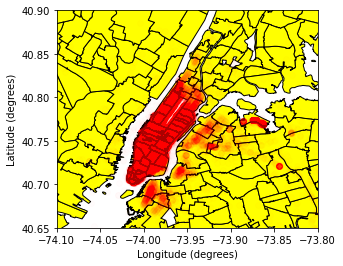

In [0]:
zoneGpd = gpd.GeoDataFrame(zoneDf.toPandas(), geometry="zone")
taxiGpd = gpd.GeoDataFrame(taxidf.toPandas(), geometry="pickup")

zone = zoneGpd.plot(color='yellow', edgecolor='black', zorder=1)
zone.set_xlabel('Longitude (degrees)')
zone.set_ylabel('Latitude (degrees)')

# Local view
zone.set_xlim(-74.1, -73.8)
zone.set_ylim(40.65, 40.9)

taxi = taxiGpd.plot(ax=zone, alpha=0.01, color='red', zorder=3)

# Geofence query to only keep records in Manhattan

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field pickup. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: GeometryType()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field zone. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: GeometryType()
At

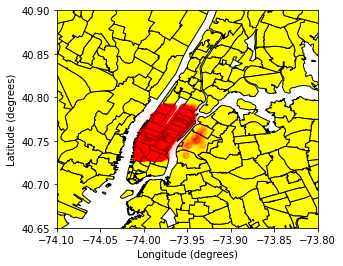

In [0]:
taxidf_mhtn = taxidf.where('ST_Contains(ST_PolygonFromEnvelope(-74.01,40.73,-73.93,40.79), pickup)')

taxiGpdMhtn = gpd.GeoDataFrame(taxidf_mhtn.toPandas(), geometry="pickup")
zoneGpd = gpd.GeoDataFrame(zoneDf.toPandas(), geometry="zone")
zone = zoneGpd.plot(color='yellow', edgecolor='black', zorder=1)
zone.set_xlabel('Longitude (degrees)')
zone.set_ylabel('Latitude (degrees)')

# Local view
zone.set_xlim(-74.1, -73.8)
zone.set_ylim(40.65, 40.9)
taxi = taxiGpdMhtn.plot(ax=zone, alpha=0.01, color='red', zorder=3)